# various approches

In [117]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## load data

In [2]:
train_df = pd.read_csv("open/train.csv", index_col='ID')
test_df = pd.read_csv("open/test.csv", index_col='ID')
sample_submission_df = pd.read_csv("open/sample_submission.csv")

train_df.shape, test_df.shape, sample_submission_df.shape

((7500, 10), (7500, 9), (7500, 2))

## preprocess data

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, TRAIN_0000 to TRAIN_7499
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Exercise_Duration         7500 non-null   float64
 1   Body_Temperature(F)       7500 non-null   float64
 2   BPM                       7500 non-null   float64
 3   Height(Feet)              7500 non-null   float64
 4   Height(Remainder_Inches)  7500 non-null   float64
 5   Weight(lb)                7500 non-null   float64
 6   Weight_Status             7500 non-null   object 
 7   Gender                    7500 non-null   object 
 8   Age                       7500 non-null   int64  
 9   Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 644.5+ KB


### convert column types

In [4]:
# convert gender column type
train_df['Gender'] = train_df['Gender'].replace('F', 0).replace('M', 1)
test_df['Gender'] = test_df['Gender'].replace('F', 0).replace('M', 1)

In [5]:
# convert weight_status column type
train_df['Weight_Status'] = train_df['Weight_Status'].replace('Normal Weight', 0).replace('Overweight', 1).replace('Obese', 2)
test_df['Weight_Status'] = test_df['Weight_Status'].replace('Normal Weight', 0).replace('Overweight', 1).replace('Obese', 2)

In [6]:
# train_df = pd.get_dummies(train_df)
# test_df = pd.get_dummies(test_df)

In [7]:
x_cols = [x for x in train_df.columns if x != 'Calories_Burned']

In [8]:
train_x = train_df.loc[:, x_cols]
train_y = train_df.loc[:, 'Calories_Burned']

train_x.shape, train_y.shape

((7500, 9), (7500,))

### feature engineering

Exercise_Duration, Body_Temperature(F) exp

In [9]:
train_x['Body_Temperature(F)'] = train_x['Body_Temperature(F)']**30
test_df['Body_Temperature(F)'] = test_df['Body_Temperature(F)']**30

## convert height, weights

In [10]:
def convert_units(weight_lb, height_feet, height_inches):
    weight_kg = weight_lb/2.205
    height_m = height_feet/3.281 + height_inches/39.37

    bmi = weight_kg/(height_m**2)
    return weight_kg, height_m, bmi

In [11]:
train_x.columns

Index(['Exercise_Duration', 'Body_Temperature(F)', 'BPM', 'Height(Feet)',
       'Height(Remainder_Inches)', 'Weight(lb)', 'Weight_Status', 'Gender',
       'Age'],
      dtype='object')

In [12]:
weight_kg, height_m, bmi = convert_units(
    train_x['Weight(lb)'], train_x['Height(Feet)'], train_x['Height(Remainder_Inches)'])

train_x['height'] = height_m
train_x['weight'] = weight_kg
train_x['bmi'] = bmi

train_x.drop(columns=['Weight(lb)', 'Height(Feet)', 'Height(Remainder_Inches)'], inplace=True)

In [13]:
weight_kg, height_m, bmi = convert_units(
    test_df['Weight(lb)'], test_df['Height(Feet)'], test_df['Height(Remainder_Inches)'])

test_df['height'] = height_m
test_df['weight'] = weight_kg
test_df['bmi'] = bmi

test_df.drop(columns=['Weight(lb)', 'Height(Feet)', 'Height(Remainder_Inches)'], inplace=True)

## BMR

In [14]:
train_x.loc[train_x['Gender']==0, 'BMR'] = 655.1 +\
    (train_x.loc[train_x['Gender']==0, 'weight']*9.563) +\
    (train_x.loc[train_x['Gender']==0, 'height']*100*1.850) +\
    (train_x.loc[train_x['Gender']==0, 'Age']*4.676)

In [15]:
train_x.loc[train_x['Gender']==1, 'BMR'] = 66.5 +\
    (train_x.loc[train_x['Gender']==1, 'weight']*13.75) +\
    (train_x.loc[train_x['Gender']==1, 'height']*100*5.003) +\
    (train_x.loc[train_x['Gender']==1, 'Age']*6.75)

In [16]:
test_df.loc[test_df['Gender']==0, 'BMR'] = 655.1 +\
    (test_df.loc[test_df['Gender']==0, 'weight']*9.563) +\
    (test_df.loc[test_df['Gender']==0, 'height']*100*1.850) +\
    (test_df.loc[test_df['Gender']==0, 'Age']*4.676)

In [17]:
test_df.loc[test_df['Gender']==1, 'BMR'] = 66.5 +\
    (test_df.loc[test_df['Gender']==1, 'weight']*13.75) +\
    (test_df.loc[test_df['Gender']==1, 'height']*100*5.003) +\
    (test_df.loc[test_df['Gender']==1, 'Age']*6.75)

<Axes: >

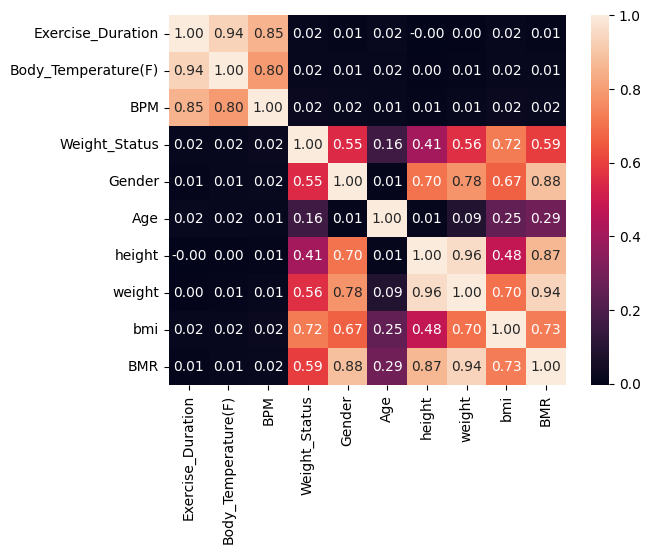

In [18]:
# train_df['Body_Temperature(F)'] = train_df['Body_Temperature(F)']**30
sns.heatmap(train_x.corr(), annot=True, fmt='.2f')

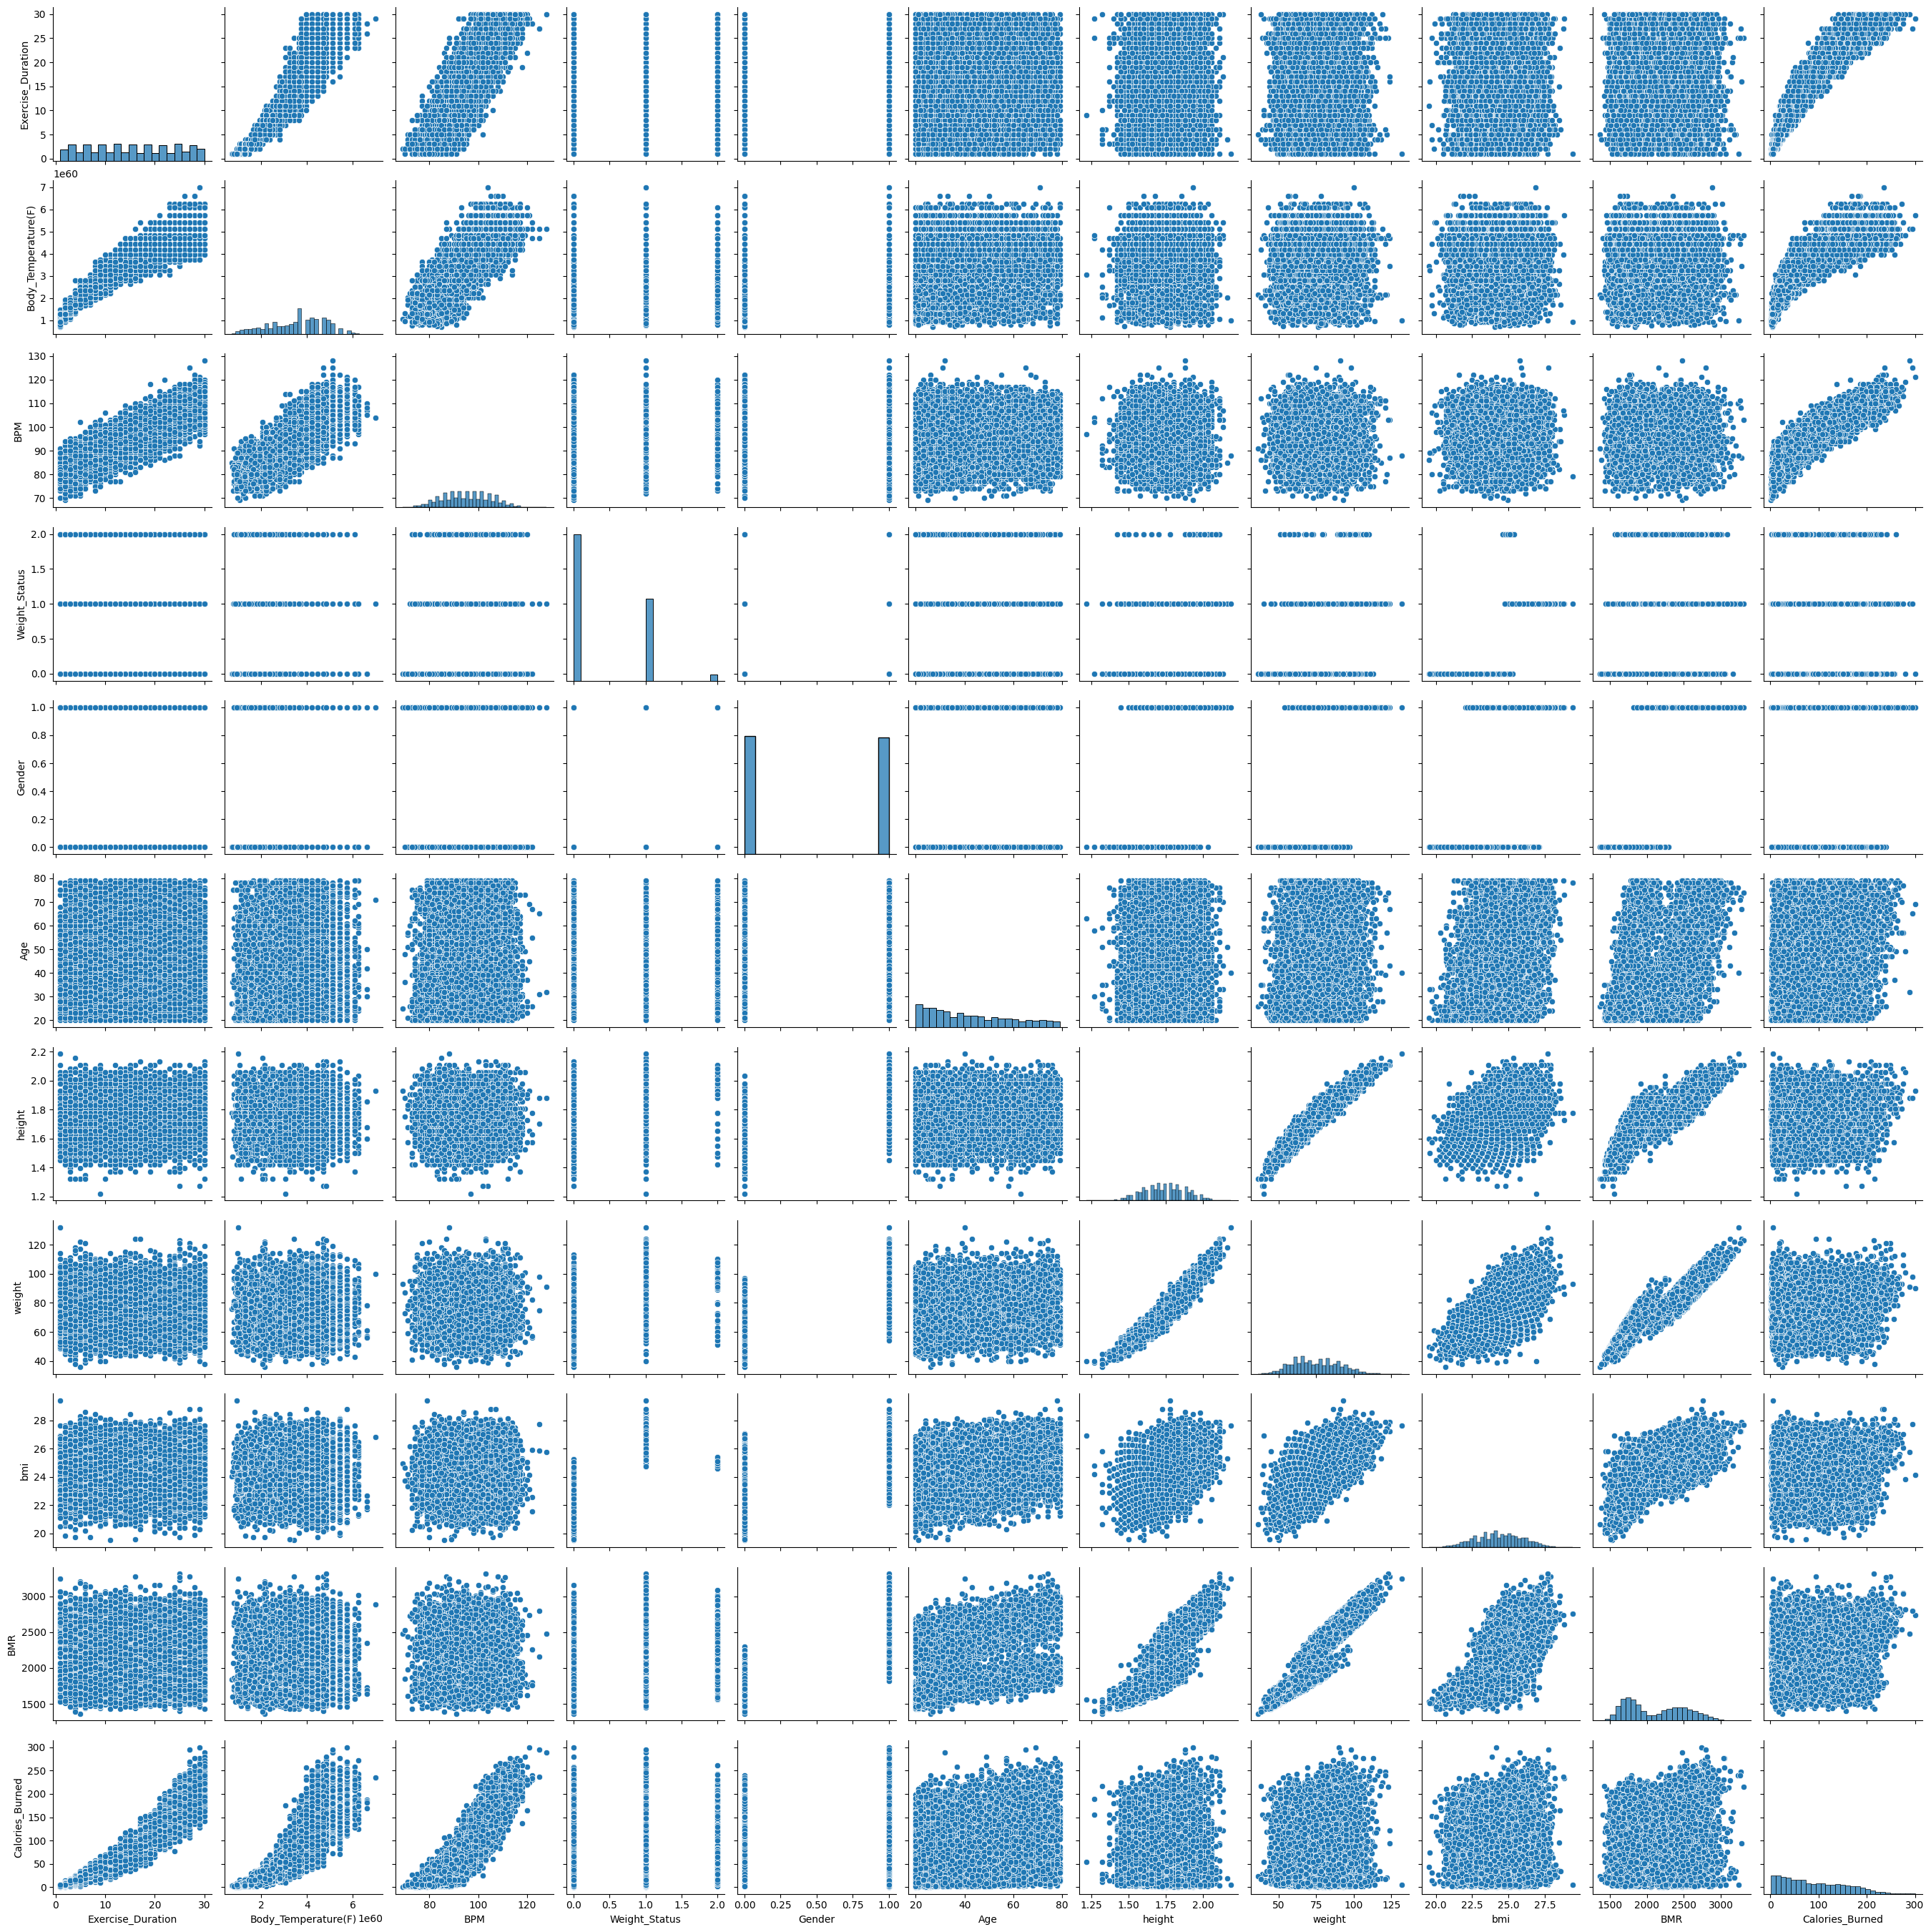

In [19]:
sns.pairplot(pd.concat([train_x, train_y], axis=1))

# pca

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(train_x)
print(pca.explained_variance_ratio_)

[1.00000000e+000 1.11189928e-115]


<Axes: xlabel='pc1', ylabel='pc2'>

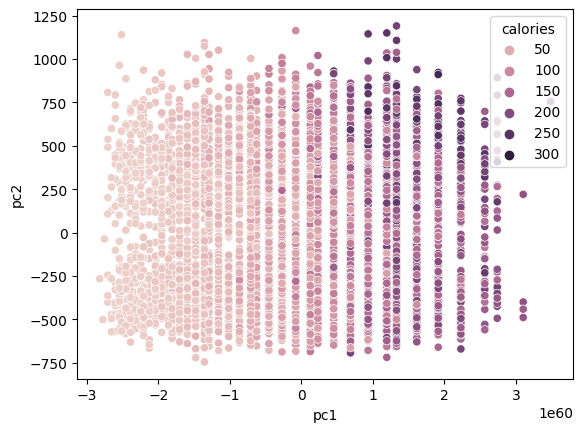

In [22]:
train_pc_df = pd.DataFrame(
    np.concatenate([pcs, np.expand_dims(train_y.values, axis=1)], axis=1), 
    columns=['pc1', 'pc2', 'calories'])
sns.scatterplot(x='pc1', y='pc2', hue='calories', data=train_pc_df)

In [23]:
test_pc_df = pca.transform(test_df.values)
test_pc_df[:, :5]

/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[ 9.32652459e+59, -4.70124965e+02],
       [ 6.85654007e+59,  2.67718251e+02],
       [-2.71096986e+59,  2.78265966e+02],
       ...,
       [ 9.32652459e+59, -4.12054826e+02],
       [-1.01553073e+60, -3.45235306e+02],
       [ 1.61314573e+60, -4.47579161e+02]])

## concat original and pc_df

In [24]:
train_array = np.concatenate([train_x.values, train_pc_df.values[:, :2]], axis=1)
test_array = np.concatenate([test_df.values, test_pc_df], axis=1)

train_array.shape, test_array.shape

((7500, 12), (7500, 12))

## normalization

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()

train_x_scaled = scaler.fit_transform(train_array)
test_x_scaled = scaler.transform(test_array)

# scaler = StandardScaler()
# train_y_scaled = np.squeeze(scaler.fit_transform([train_y.values]))
train_x_scaled.shape, test_x_scaled.shape

((7500, 12), (7500, 12))

In [27]:
# scaler = StandardScaler()

# train_x_scaled = scaler.fit_transform(train_x.values)
# test_x_scaled = scaler.transform(test_df.values)

# # scaler = StandardScaler()
# # train_y_scaled = np.squeeze(scaler.fit_transform([train_y.values]))
# train_x_scaled.shape, test_x_scaled.shape

In [28]:
train_x_scaled.min(), train_x_scaled.max(), test_x_scaled.min(), test_x_scaled.max()

(-3.672933034530152,
 3.772267272434373,
 -3.1743209662629237,
 3.5080499408893075)

In [29]:
# scaler = StandardScaler()
# train_y_scaled = np.squeeze(scaler.fit_transform(np.expand_dims(train_y.values, axis=1)))
# train_y_scaled

## train test split

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train_x_, val_x_, train_y_, val_y_ = train_test_split(train_x_scaled, train_y, shuffle=True, random_state=42)

## modeling

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

In [33]:
# for k, v in models.items():
#     print(f'------ {k} -------')
    
#     # train
#     v.fit(train_x_scaled, train_y)
    
#     # predict
#     train_pred = v.predict(train_x_scaled)
#     test_pred = v.predict(test_x_scaled)
    
#     # evaluate
#     train_rmse = mean_squared_error(train_y, train_pred, squared=False)
#     train_r2 = r2_score(train_y, train_pred)
    
#     print('train_rmse: ', train_rmse)
#     print('train_r2: ', train_r2)

In [34]:
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

In [35]:
# for k, v in models.items():
#     print(f'------ {k} -------')
    
#     # train
#     v.fit(train_x_scaled, train_y)
    
#     # predict
#     train_pred = v.predict(train_x_scaled)
#     test_pred = v.predict(test_x_scaled)
    
#     # evaluate
#     train_rmse = mean_squared_error(train_y, train_pred, squared=False)
#     train_r2 = r2_score(train_y, train_pred)
    
#     print('train_rmse: ', train_rmse)
#     print('train_r2: ', train_r2)

각각 하나씩 봐야할 것 같음. 보면서 블로그 쓰는 것이 좋을 듯.

정확하게!!

In [36]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [37]:
# model = GradientBoostingRegressor()
# parameters = {"learning_rate": sp_randFloat(),
#               "subsample"    : sp_randFloat(),
#               "n_estimators" : sp_randInt(100, 1000),
#               "max_depth"    : sp_randInt(4, 10)
#              }

In [38]:
# cv = RandomizedSearchCV(model, parameters, n_iter=1, cv=10)
# cv.fit(train_x_scaled, train_y)

In [39]:
# cv.best_params_

In [40]:
# cv.best_score_

In [41]:
# train_pred = cv.predict(train_x_scaled)

# # evaluate
# train_rmse = mean_squared_error(train_y, train_pred, squared=False)
# train_r2 = r2_score(train_y, train_pred)

# print('train_rmse: ', train_rmse)
# print('train_r2: ', train_r2)

In [42]:
# test_pred = cv.predict(test_x_scaled)

In [43]:
# sample_submission_df['Calories_Burned'] = test_pred
# sample_submission_df

In [44]:
# sample_submission_df.to_csv(

In [45]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [2,4]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

In [46]:
# # Create the param grid
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(param_grid)

In [47]:
# from sklearn.model_selection import GridSearchCV
# model = RandomForestRegressor()
# rf_Grid = GridSearchCV(
#     estimator=model, param_grid=param_grid, cv=10, verbose=2, n_jobs=4, scoring='neg_root_mean_squared_error', refit=True)
# rf_Grid.fit(train_x_scaled, train_y)

In [48]:
# rf_Grid.best_params_

In [49]:
# rf_Grid.score(train_x_scaled, train_y)

In [50]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score

In [51]:


# rf_RandomGrid = RandomizedSearchCV(
#     estimator=rf_Model, 
#     param_distributions=param_grid, 
#     cv=10, 
#     verbose=2, 
#     n_jobs=4
# )

In [52]:
max_depth = sp_randInt(2, 10)
n_estimators = sp_randInt(100, 1000)
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = [None, 'sqrt', 'log2']
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [53]:
name_2_model = {
    'knn': KNeighborsRegressor(),
    'linear_regression': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic_net': ElasticNet(),
    'random_forest': RandomForestRegressor(),
    'gradientboost': GradientBoostingRegressor(),
    # 'svr': SVR(),
}
name_2_params = {
    'knn': {'n_neighbors': [3, 5, 7]},
    'ridge': {
        'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001],
        'max_iter': [1000, 10000, 100000, 100000],
    },
    'lasso': {
        'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001],
        'max_iter': [1000, 10000, 100000, 100000],
    },
    'elastic_net': {
        'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001],
        'max_iter': [1000, 10000, 100000, 100000],
        'l1_ratio': [0.1, 0.5, 0.9],
    },
    'random_forest': {
        "max_depth"    : max_depth,
        'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    },
    'gradientboost': {
        "n_estimators" : n_estimators,
        "max_depth"    : max_depth,
        "learning_rate": sp_randFloat(),
        "subsample"    : sp_randFloat(),
    },
    'svr': {
        'kernel' : ['poly'],
        'C' : [0.01, 0.1, 1, 10],
        'gamma' : [0.01, 0.1, 1, 10],
    },
}

In [54]:
for mname in name_2_model.keys():
    print(f'------ {mname} -------')
    model = name_2_model[mname]
    
    # train
    if mname in name_2_params.keys():
        params = name_2_params[mname]
        RandomGrid = RandomizedSearchCV(
            estimator=model, 
            param_distributions=params, 
            cv=10, 
            verbose=1, 
            n_jobs=4,
            scoring='neg_root_mean_squared_error', 
            refit=True,
            random_state=42
        )
    else:
        RandomGrid = model
    
    RandomGrid = RandomGrid.fit(train_x_, train_y_)
    
    # predict
    train_pred = RandomGrid.predict(train_x_)
    val_pred = RandomGrid.predict(val_x_)
    test_pred = RandomGrid.predict(test_x_scaled)
    
#     train_y_inverse = scaler.inverse_transform(np.expand_dims(train_y_, axis=1))
#     val_y_inverse = scaler.inverse_transform(np.expand_dims(val_y_, axis=1))

#     train_pred = scaler.inverse_transform(np.expand_dims(train_pred, axis=1))
#     val_pred = scaler.inverse_transform(np.expand_dims(val_pred, axis=1))
#     test_pred = scaler.inverse_transform(np.expand_dims(test_pred, axis=1))

    
    # evaluate
    train_rmse = mean_squared_error(train_y_, train_pred, squared=False)
    val_rmse = mean_squared_error(val_y_, val_pred, squared=False)
    train_r2 = r2_score(train_y_, train_pred)
    val_r2 = r2_score(val_y_, val_pred)
    
    print('train_rmse: ', train_rmse)
    print('val_rmse: ', val_rmse)
    print('train_r2: ', train_r2)
    print('val_r2: ', val_r2)

------ knn -------
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


train_rmse:  7.8963333148110015
val_rmse:  8.998548031025154
train_r2:  0.984190492682842
val_r2:  0.9794984996435279
------ linear_regression -------
train_rmse:  11.423864954604001
val_rmse:  11.250537606485329
train_r2:  0.9669102479756547
val_r2:  0.9679530045833975
------ ridge -------
Fitting 10 folds for each of 10 candidates, totalling 100 fits
train_rmse:  11.423649100017458
val_rmse:  11.251743518684235
train_r2:  0.9669114984293831
val_r2:  0.967946134167915
------ lasso -------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+05, tolerance: 1.993e+03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+05, tolerance: 1.985e+03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

train_rmse:  11.423591874621902
val_rmse:  11.250822482754021
train_r2:  0.9669118299342869
val_r2:  0.9679513816308987
------ elastic_net -------
Fitting 10 folds for each of 10 candidates, totalling 100 fits
train_rmse:  11.424904534049453
val_rmse:  11.25703163255816
train_r2:  0.9669042253219589
val_r2:  0.9679159976251924
------ random_forest -------
Fitting 10 folds for each of 10 candidates, totalling 100 fits
train_rmse:  5.09677982917687
val_rmse:  6.056796956607733
train_r2:  0.9934134326321421
val_r2:  0.9907119018347557
------ gradientboost -------
Fitting 10 folds for each of 10 candidates, totalling 100 fits
train_rmse:  0.4886792130869096
val_rmse:  2.27280594078582
train_r2:  0.9999394498639562
val_r2:  0.9986921272876927


* knn, random_forest 결과가 좋은 편
* gradientboost 최고

In [55]:
mname = 'gradientboost'
model = name_2_model[mname]

# train
if mname in name_2_params.keys():
    params = name_2_params[mname]
    RandomGrid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=params, 
        cv=10, 
        verbose=2, 
        n_jobs=4,
        scoring='neg_root_mean_squared_error', 
        refit=True,
        random_state=42
    )
else:
    RandomGrid = model

RandomGrid = RandomGrid.fit(train_x_scaled, train_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [56]:
RandomGrid.best_score_

-1.9822868994905307

In [57]:
RandomGrid.best_params_

{'learning_rate': 0.13949386065204183,
 'max_depth': 5,
 'n_estimators': 799,
 'subsample': 0.3663618432936917}

In [58]:
dir(RandomGrid)[-20:]

['n_features_in_',
 'n_iter',
 'n_jobs',
 'n_splits_',
 'param_distributions',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'refit',
 'refit_time_',
 'return_train_score',
 'score',
 'score_samples',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [59]:
RandomGrid.score(train_x_scaled, train_y)

-0.5684191148692775

In [60]:
train_pred = RandomGrid.predict(train_x_scaled)
# train_pred = scaler.inverse_transform(np.expand_dims(train_pred, axis=1))
# train_y_inverse = scaler.inverse_transform(np.expand_dims(train_y_scaled, axis=1))

train_rmse = mean_squared_error(train_y, train_pred, squared=False)
train_r2 = r2_score(train_y, train_pred)

train_rmse, train_r2

(0.5684191148692775, 0.9999181083371509)

In [61]:
# predict
train_pred = RandomGrid.predict(train_x_)
val_pred = RandomGrid.predict(val_x_)
test_pred = RandomGrid.predict(test_x_scaled)

# train_y_inverse = scaler.inverse_transform(np.expand_dims(train_y_, axis=1))
# val_y_inverse = scaler.inverse_transform(np.expand_dims(val_y_, axis=1))

# train_pred = scaler.inverse_transform(np.expand_dims(train_pred, axis=1))
# val_pred = scaler.inverse_transform(np.expand_dims(val_pred, axis=1))
# test_pred = scaler.inverse_transform(np.expand_dims(test_pred, axis=1))


# evaluate
train_rmse = mean_squared_error(train_y_, train_pred, squared=False)
val_rmse = mean_squared_error(val_y_, val_pred, squared=False)
train_r2 = r2_score(train_y_, train_pred)
val_r2 = r2_score(val_y_, val_pred)

print('train_rmse: ', train_rmse)
print('val_rmse: ', val_rmse)
print('train_r2: ', train_r2)
print('val_r2: ', val_r2)

train_rmse:  0.5691621359311988
val_rmse:  0.5661842011764355
train_r2:  0.9999178628948366
val_r2:  0.9999188373422228


In [62]:
from datetime import datetime as dt

def make_report(template, test_pred, mname):
    template['Calories_Burned'] = test_pred
    now = dt.strftime(dt.now(), '%y-%m-%d')
    template.to_csv(f'{mname}-{now}-2.csv', index=False)
    
make_report(sample_submission_df, test_pred, mname)

[CV] END learning_rate=0.3745401188473625, max_depth=6, n_estimators=370, subsample=0.7319939418114051; total time=   5.5s
[CV] END learning_rate=0.3745401188473625, max_depth=6, n_estimators=370, subsample=0.7319939418114051; total time=   5.5s
[CV] END learning_rate=0.3745401188473625, max_depth=6, n_estimators=370, subsample=0.7319939418114051; total time=   5.5s
[CV] END learning_rate=0.05808361216819946, max_depth=9, n_estimators=472, subsample=0.6011150117432088; total time=   8.4s
[CV] END learning_rate=0.05808361216819946, max_depth=9, n_estimators=472, subsample=0.6011150117432088; total time=   8.4s
[CV] END learning_rate=0.7080725777960455, max_depth=7, n_estimators=408, subsample=0.9699098521619943; total time=   9.2s
[CV] END learning_rate=0.7080725777960455, max_depth=7, n_estimators=408, subsample=0.9699098521619943; total time=   9.2s
[CV] END learning_rate=0.7080725777960455, max_depth=7, n_estimators=408, subsample=0.9699098521619943; total time=   9.2s
[CV] END learn

# NN이나 XGBoost같은 다른 알고리즘 써보자.(230420)

In [65]:
import xgboost

In [84]:
xg_boost_params = {
        "n_estimators" : n_estimators,
        "max_depth"    : max_depth,
        "learning_rate": sp_randFloat(),
        "subsample"    : sp_randFloat(),
    }

In [85]:
model = xgboost.XGBRegressor()
params = xg_boost_params

RandomGrid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=params, 
    cv=10, 
    verbose=2, 
    n_jobs=4,
    scoring='neg_root_mean_squared_error', 
    refit=True,
    random_state=42
)

In [86]:
RandomGrid.fit(train_x_, train_y_, verbose=1)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x158c1ab30>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11f517310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11f517e20>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13ec20dc0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [90]:
# predict
train_pred = RandomGrid.predict(train_x_)
val_pred = RandomGrid.predict(val_x_)
test_pred = RandomGrid.predict(test_x_scaled)

# evaluate
train_rmse = mean_squared_error(train_y_, train_pred, squared=False)
val_rmse = mean_squared_error(val_y_, val_pred, squared=False)
train_r2 = r2_score(train_y_, train_pred)
val_r2 = r2_score(val_y_, val_pred)

print('train_rmse: ', train_rmse)
print('val_rmse: ', val_rmse)
print('train_r2: ', train_r2)
print('val_r2: ', val_r2)

train_rmse:  0.17435440073647124
val_rmse:  1.948056819901591
train_r2:  0.9999922921506361
val_r2:  0.9990391756365149


In [91]:
model = xgboost.XGBRegressor()
params = xg_boost_params

RandomGrid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=params, 
    cv=10, 
    verbose=2, 
    n_jobs=4,
    scoring='neg_root_mean_squared_error', 
    refit=True,
    random_state=42
)

RandomGrid.fit(train_x_scaled, train_y, verbose=1)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x158c1ab30>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11f517310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11f517e20>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13ec20dc0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [96]:
RandomGrid.best_score_

-1.7291299887625318

In [97]:
RandomGrid.best_params_

{'learning_rate': 0.05808361216819946,
 'max_depth': 9,
 'n_estimators': 472,
 'subsample': 0.6011150117432088}

In [98]:
# predict
train_pred = RandomGrid.predict(train_x_)
val_pred = RandomGrid.predict(val_x_)
test_pred = RandomGrid.predict(test_x_scaled)

# evaluate
train_rmse = mean_squared_error(train_y_, train_pred, squared=False)
val_rmse = mean_squared_error(val_y_, val_pred, squared=False)
train_r2 = r2_score(train_y_, train_pred)
val_r2 = r2_score(val_y_, val_pred)

print('train_rmse: ', train_rmse)
print('val_rmse: ', val_rmse)
print('train_r2: ', train_r2)
print('val_r2: ', val_r2)

train_rmse:  0.22225327420810545
val_rmse:  0.2287300601462139
train_r2:  0.9999874754039738
val_r2:  0.9999867539236119


In [99]:
test_pred = RandomGrid.predict(test_x_scaled)

In [100]:
from datetime import datetime as dt

def make_report(template, test_pred, mname):
    template['Calories_Burned'] = test_pred
    now = dt.strftime(dt.now(), '%y-%m-%d')
    template.to_csv(f'{mname}-{now}-1.csv', index=False)
    
make_report(sample_submission_df, test_pred, mname)

[CV] END learning_rate=0.3745401188473625, max_depth=6, n_estimators=370, subsample=0.7319939418114051; total time=   1.4s
[CV] END learning_rate=0.3745401188473625, max_depth=6, n_estimators=370, subsample=0.7319939418114051; total time=   1.4s
[CV] END learning_rate=0.3745401188473625, max_depth=6, n_estimators=370, subsample=0.7319939418114051; total time=   1.5s
[CV] END learning_rate=0.5986584841970366, max_depth=8, n_estimators=221, subsample=0.15599452033620265; total time=   0.8s
[CV] END learning_rate=0.5986584841970366, max_depth=8, n_estimators=221, subsample=0.15599452033620265; total time=   0.8s
[CV] END learning_rate=0.05808361216819946, max_depth=9, n_estimators=472, subsample=0.6011150117432088; total time=   3.2s
[CV] END learning_rate=0.05808361216819946, max_depth=9, n_estimators=472, subsample=0.6011150117432088; total time=   3.2s
[CV] END learning_rate=0.7080725777960455, max_depth=7, n_estimators=408, subsample=0.9699098521619943; total time=   1.8s
[CV] END lea

In [101]:
from sklearn.neural_network import MLPRegressor

In [105]:
params = {
    'hidden_layer_sizes': [10, 50, 100, 200],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    'batch_size': [10, 50, 100, 200, 500, 1000],
    'warm_start': [True, False],
}

In [109]:
model = MLPRegressor()

RandomGrid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=params, 
    cv=10,  
    n_jobs=4,
    scoring='neg_root_mean_squared_error', 
    refit=True,
    random_state=42,
    verbose=1,
)

RandomGrid.fit(train_x_, train_y_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2

RandomizedSearchCV(cv=10, estimator=MLPRegressor(), n_jobs=4,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'batch_size': [10, 50, 100, 200, 500,
                                                       1000],
                                        'hidden_layer_sizes': [10, 50, 100,
                                                               200],
                                        'solver': ['lbfgs', 'sgd', 'adam'],
                                        'warm_start': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [110]:
# predict
train_pred = RandomGrid.predict(train_x_)
val_pred = RandomGrid.predict(val_x_)
test_pred = RandomGrid.predict(test_x_scaled)

# evaluate
train_rmse = mean_squared_error(train_y_, train_pred, squared=False)
val_rmse = mean_squared_error(val_y_, val_pred, squared=False)
train_r2 = r2_score(train_y_, train_pred)
val_r2 = r2_score(val_y_, val_pred)

print('train_rmse: ', train_rmse)
print('val_rmse: ', val_rmse)
print('train_r2: ', train_r2)
print('val_r2: ', val_r2)

train_rmse:  0.45038109747243527
val_rmse:  0.5453348109374172
train_r2:  0.9999485686763921
val_r2:  0.9999247048141519


In [113]:
RandomGrid.best_score_

-0.5765445306597206

In [114]:
model = MLPRegressor()

RandomGrid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=params, 
    cv=10,  
    n_jobs=4,
    scoring='neg_root_mean_squared_error', 
    refit=True,
    random_state=42,
    verbose=1,
)

RandomGrid.fit(train_x_scaled, train_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/recsys/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2

RandomizedSearchCV(cv=10, estimator=MLPRegressor(), n_jobs=4,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'batch_size': [10, 50, 100, 200, 500,
                                                       1000],
                                        'hidden_layer_sizes': [10, 50, 100,
                                                               200],
                                        'solver': ['lbfgs', 'sgd', 'adam'],
                                        'warm_start': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [115]:
# predict
train_pred = RandomGrid.predict(train_x_)
val_pred = RandomGrid.predict(val_x_)
test_pred = RandomGrid.predict(test_x_scaled)

# evaluate
train_rmse = mean_squared_error(train_y_, train_pred, squared=False)
val_rmse = mean_squared_error(val_y_, val_pred, squared=False)
train_r2 = r2_score(train_y_, train_pred)
val_r2 = r2_score(val_y_, val_pred)

print('train_rmse: ', train_rmse)
print('val_rmse: ', val_rmse)
print('train_r2: ', train_r2)
print('val_r2: ', val_r2)

train_rmse:  0.4363129107668416
val_rmse:  0.41294705638074114
train_r2:  0.9999517315314388
val_r2:  0.9999568252813437


In [116]:
from datetime import datetime as dt

def make_report(template, test_pred, mname):
    template['Calories_Burned'] = test_pred
    now = dt.strftime(dt.now(), '%y-%m-%d')
    template.to_csv(f'{mname}-{now}-3.csv', index=False)
    
make_report(sample_submission_df, test_pred, mname)

[CV] END activation=logistic, alpha=1, batch_size=1000, hidden_layer_sizes=200, solver=sgd, warm_start=True; total time=   0.0s
[CV] END activation=relu, alpha=1, batch_size=10, hidden_layer_sizes=50, solver=sgd, warm_start=False; total time=   0.0s
[CV] END activation=relu, alpha=1, batch_size=10, hidden_layer_sizes=50, solver=sgd, warm_start=False; total time=   0.0s
[CV] END activation=relu, alpha=1, batch_size=10, hidden_layer_sizes=50, solver=sgd, warm_start=False; total time=   0.0s
[CV] END activation=relu, alpha=1, batch_size=10, hidden_layer_sizes=50, solver=sgd, warm_start=False; total time=   0.0s
[CV] END activation=identity, alpha=0.001, batch_size=50, hidden_layer_sizes=50, solver=adam, warm_start=True; total time=   0.0s
[CV] END activation=identity, alpha=0.001, batch_size=50, hidden_layer_sizes=50, solver=adam, warm_start=True; total time=   0.0s
[CV] END activation=identity, alpha=0.001, batch_size=50, hidden_layer_sizes=50, solver=adam, warm_start=True; total time=  